# ARFS - Using GPU

You can leverage the GPU implementation of lightGBM (or other GBM flavours) but this often requires to compile or install some libraries or kit (such as CUDA)

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

import arfs
from arfs.feature_selection import GrootCV, Leshy
from arfs.utils import load_data
from arfs.benchmark import highlight_tick

rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

## GrootCV on GPU

If the data is small, using a GPU mught not be the most efficient.

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Generate synthetic data with Poisson-distributed target variable
bias = 1

n_samples = 100_00 #1_000_000
n_features = 100
n_informative = 20

X, y, true_coef = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    noise=1,
    random_state=8,
    bias=bias,
    coef=True,
)
y = (y - y.mean()) / y.std()
y = np.exp(y)  # Transform to positive values for Poisson distribution
y = np.random.poisson(y)  # Add Poisson noise to the target variable
# dummy sample weight (e.g. exposure), smallest being 30 days
w = np.random.uniform(30 / 365, 1, size=len(y))
# make the count a Poisson rate (frequency)
y = y / w

X = pd.DataFrame(X)
X.columns = [f"pred_{i}" for i in range(X.shape[1])]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.5, random_state=42
)

true_coef = pd.Series(true_coef)
true_coef.index = X.columns
true_coef = pd.Series({**{"intercept": bias}, **true_coef})
true_coef

genuine_predictors = true_coef[true_coef > 0.0]

print(f"The true coefficient of the linear data generating process are:\n {true_coef}")

The true coefficient of the linear data generating process are:
 intercept     1.000000
pred_0        0.000000
pred_1        0.000000
pred_2        4.880441
pred_3        0.000000
               ...    
pred_95       0.000000
pred_96       0.000000
pred_97      82.010316
pred_98       0.000000
pred_99       0.000000
Length: 101, dtype: float64


GPU

Repeated k-fold:   0%|          | 0/9 [00:00<?, ?it/s]

The selected features: ['pred_6' 'pred_11' 'pred_29' 'pred_34' 'pred_49' 'pred_55' 'pred_61'
 'pred_62' 'pred_64' 'pred_68' 'pred_75' 'pred_81' 'pred_84' 'pred_87'
 'pred_93' 'pred_97']
The agnostic ranking: [1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 2 2 1 2 1 1 1 2 1 1 1 1 1
 1 2 1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 2 1 1]
The naive ranking: ['pred_87', 'pred_29', 'pred_62', 'pred_97', 'pred_84', 'pred_75', 'pred_68', 'pred_11', 'pred_49', 'pred_55', 'pred_81', 'pred_64', 'pred_6', 'pred_93', 'pred_61', 'pred_34', 'pred_57', 'pred_76', 'pred_39', 'pred_91', 'pred_14', 'pred_25', 'pred_0', 'pred_37', 'pred_50', 'pred_5', 'pred_52', 'pred_58', 'pred_70', 'pred_48', 'pred_54', 'pred_78', 'pred_12', 'pred_27', 'pred_65', 'pred_53', 'pred_46', 'pred_47', 'pred_86', 'pred_90', 'pred_60', 'pred_9', 'pred_31', 'pred_99', 'pred_56', 'pred_88', 'pred_38', 'pred_7', 'pred_10', 'pred_74', 'pred_19', 'pred_15', '

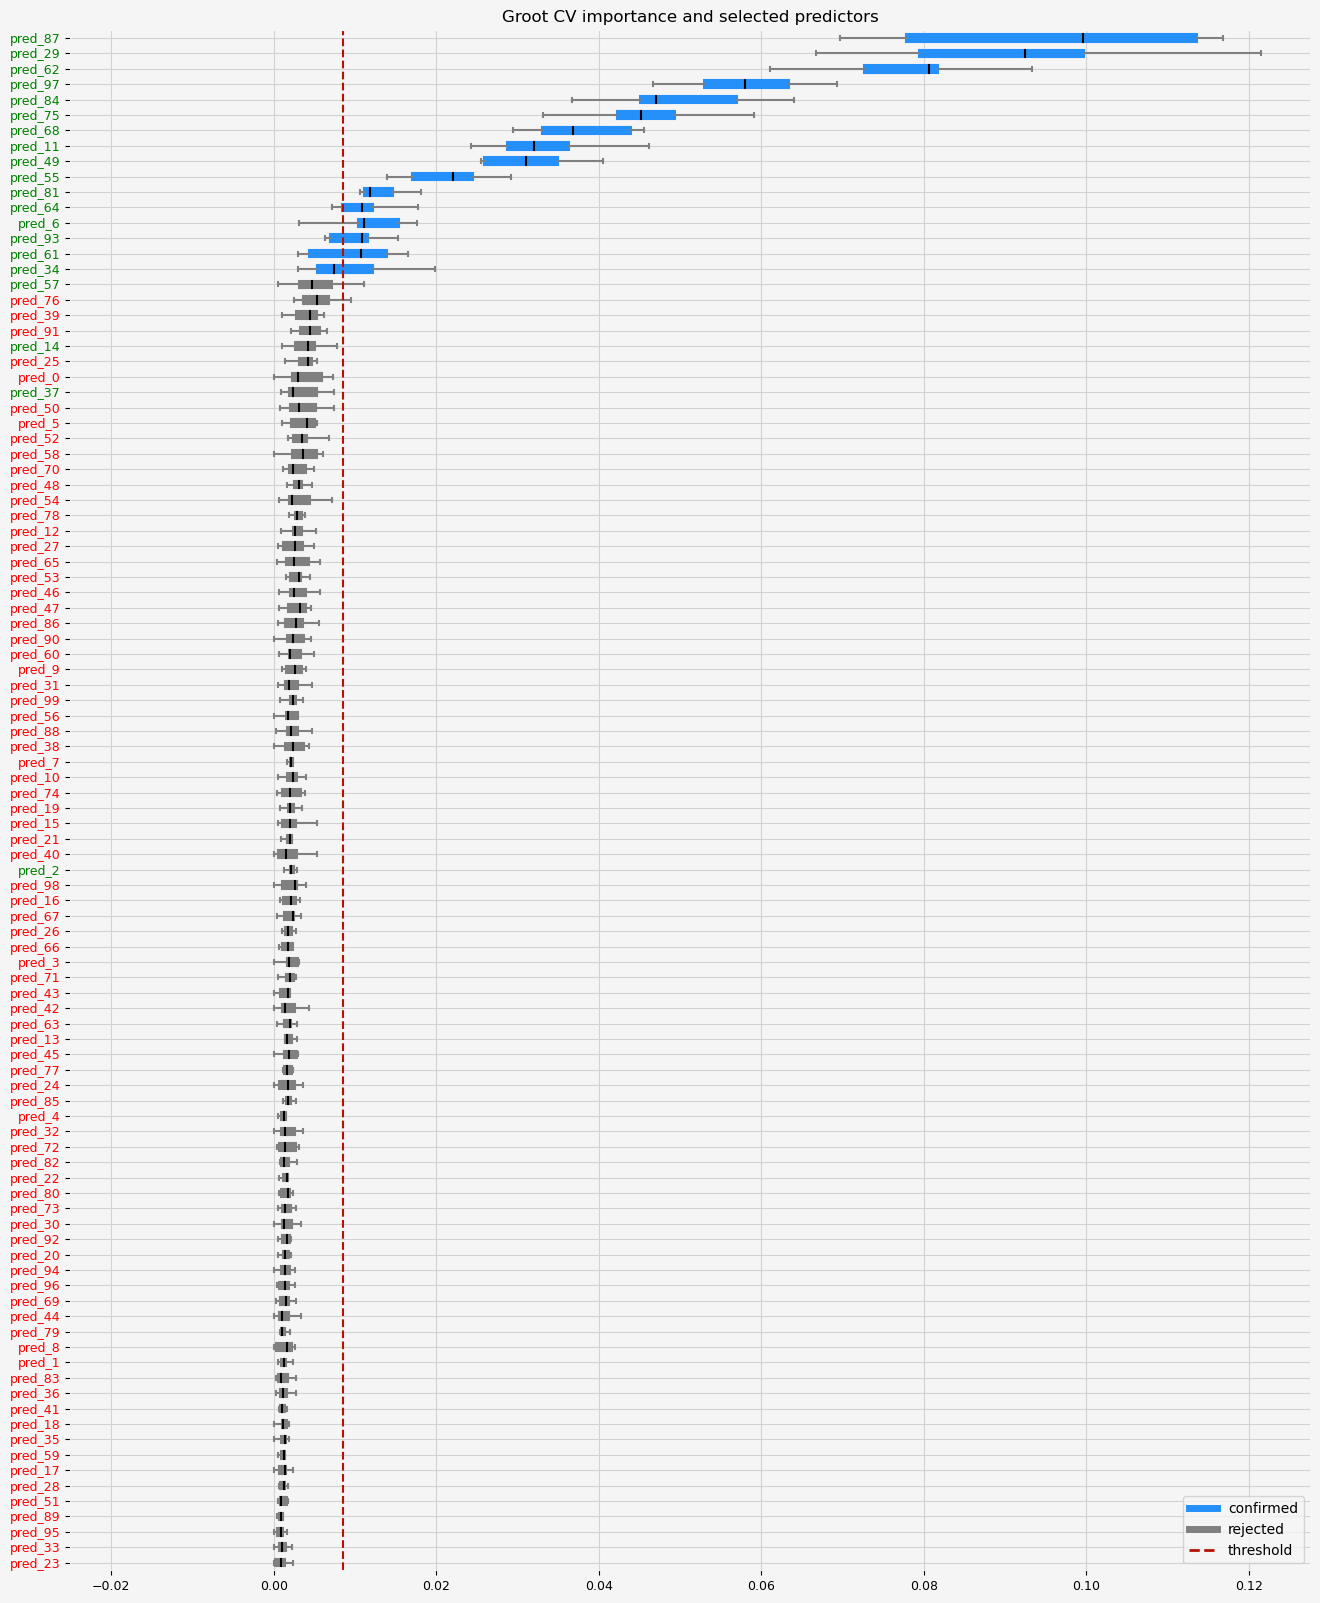

CPU times: total: 2min 38s
Wall time: 50.1 s


In [3]:
%%time
feat_selector = GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=3,
    n_iter=3,
    silent=True,
    fastshap=True,
    n_jobs=0,
    lgbm_params={"device": "gpu", "gpu_device_id": 1},
)
feat_selector.fit(X_train, y_train, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
for name in true_coef.index:
    if name in genuine_predictors.index:
        fig = highlight_tick(figure=fig, str_match=name, color="green")
    else:
        fig = highlight_tick(figure=fig, str_match=name)

plt.show()

CPU

Repeated k-fold:   0%|          | 0/9 [00:00<?, ?it/s]

The selected features: ['pred_6' 'pred_11' 'pred_29' 'pred_34' 'pred_49' 'pred_55' 'pred_61'
 'pred_62' 'pred_64' 'pred_68' 'pred_75' 'pred_81' 'pred_84' 'pred_87'
 'pred_93' 'pred_97']
The agnostic ranking: [1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 2 2 1 2 1 1 1 2 1 1 1 1 1
 1 2 1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 2 1 1]
The naive ranking: ['pred_87', 'pred_29', 'pred_62', 'pred_97', 'pred_84', 'pred_75', 'pred_68', 'pred_11', 'pred_49', 'pred_55', 'pred_81', 'pred_6', 'pred_64', 'pred_93', 'pred_61', 'pred_34', 'pred_57', 'pred_76', 'pred_50', 'pred_91', 'pred_39', 'pred_37', 'pred_14', 'pred_0', 'pred_5', 'pred_25', 'pred_58', 'pred_65', 'pred_86', 'pred_48', 'pred_52', 'pred_53', 'pred_78', 'pred_47', 'pred_88', 'pred_70', 'pred_27', 'pred_99', 'pred_9', 'pred_7', 'pred_60', 'pred_16', 'pred_21', 'pred_15', 'pred_74', 'pred_46', 'pred_54', 'pred_82', 'pred_56', 'pred_32', 'pred_31', 'pred_22', '

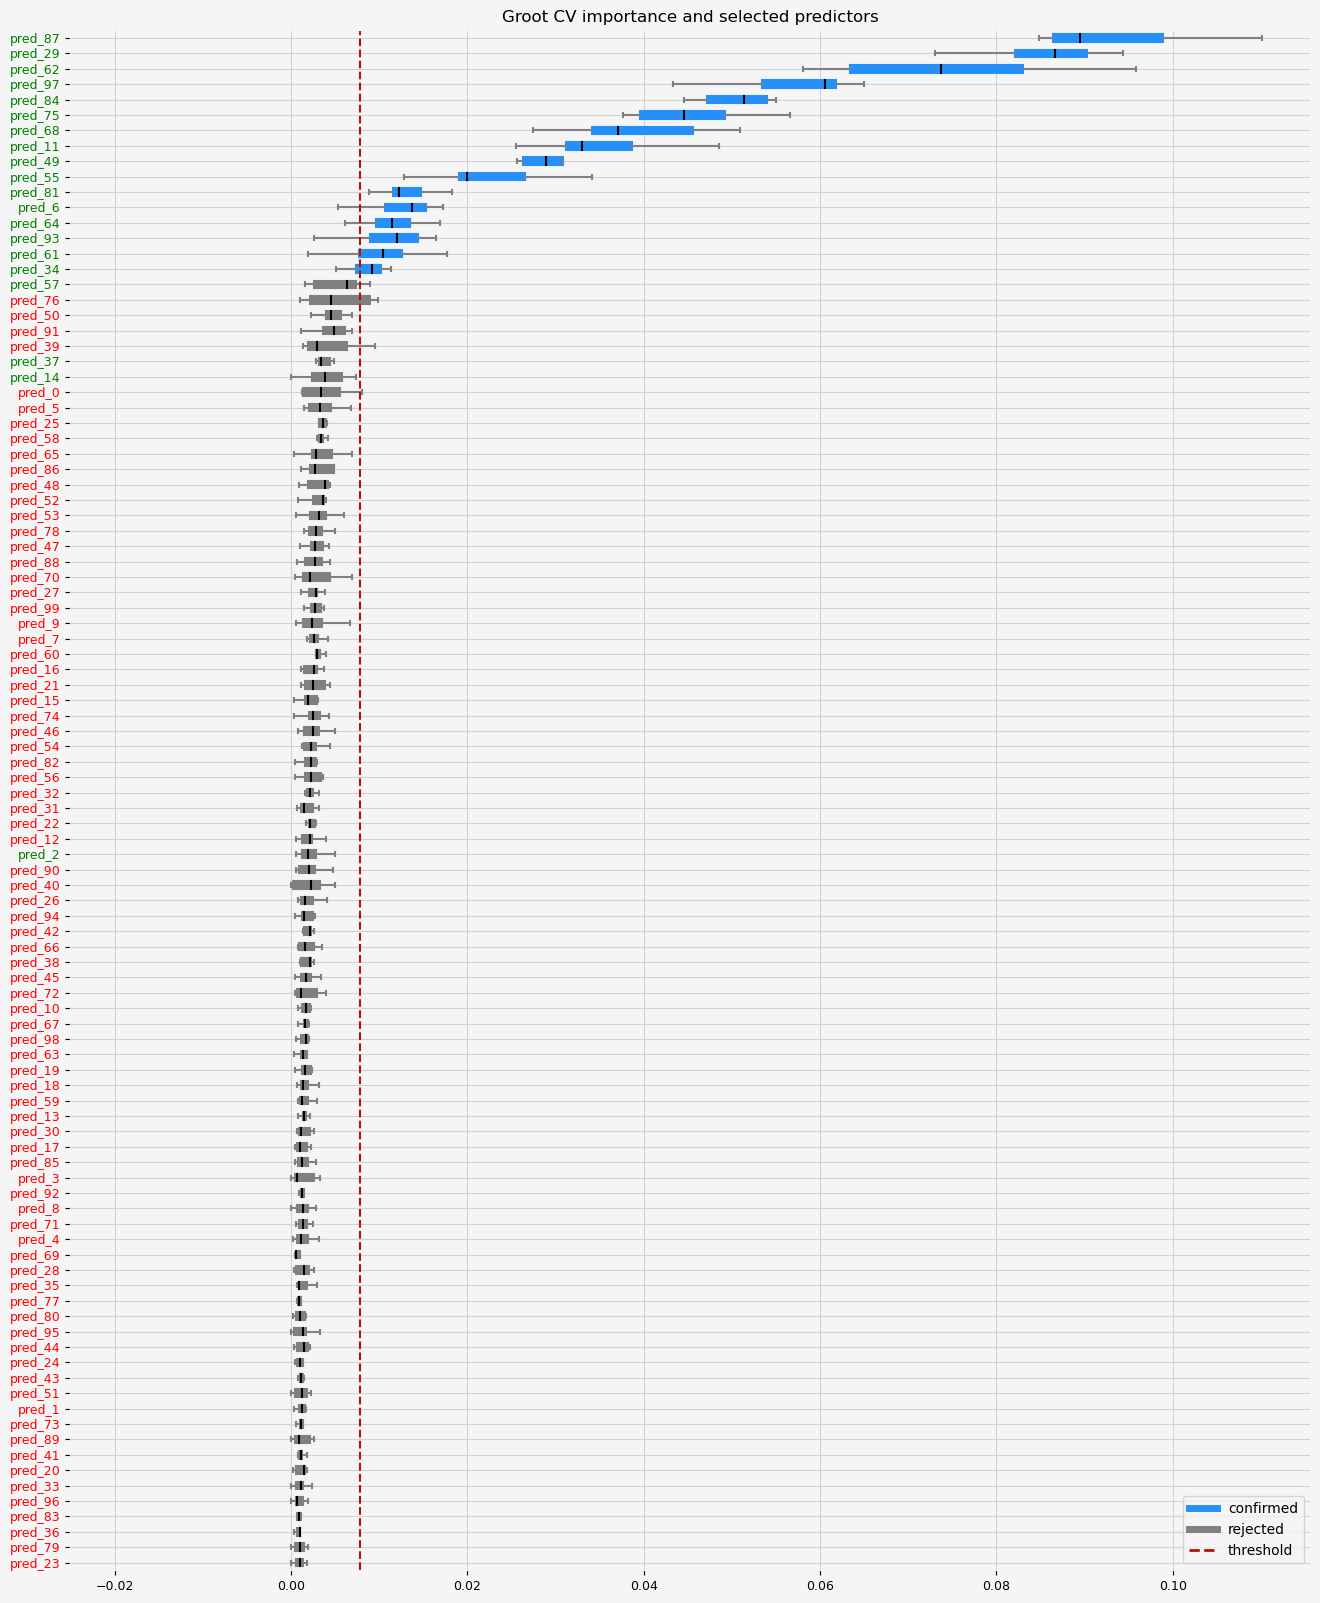

CPU times: total: 1min 18s
Wall time: 32.1 s


In [4]:
%%time
feat_selector = GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=3,
    n_iter=3,
    silent=True,
    fastshap=True,
    n_jobs=0,
    lgbm_params={"device": "cpu"},
)
feat_selector.fit(X_train, y_train, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
for name in true_coef.index:
    if name in genuine_predictors.index:
        fig = highlight_tick(figure=fig, str_match=name, color="green")
    else:
        fig = highlight_tick(figure=fig, str_match=name)

plt.show()

On a smaller data set, for illustrative purposes.

In [5]:
boston = load_data(name="Boston")
X, y = boston.data, boston.target

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']
The agnostic ranking: [2 1 1 1 2 2 2 2 1 2 2 2 2 1 1 1 1 2]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'PTRATIO', 'DIS', 'CRIM', 'NOX', 'AGE', 'TAX', 'B', 'random_num1', 'INDUS', 'random_cat', 'random_cat_2', 'RAD', 'ZN', 'random_num2', 'CHAS']


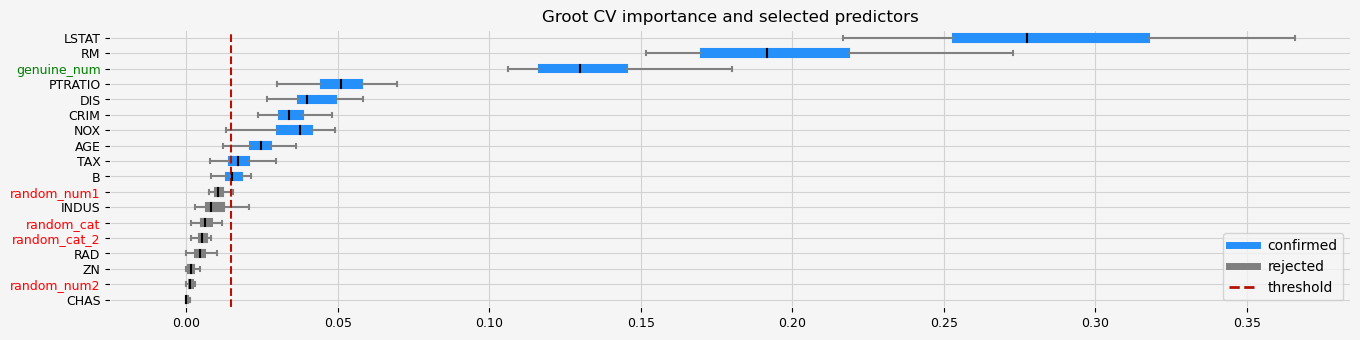

CPU times: total: 1min 2s
Wall time: 20.1 s


In [6]:
%%time
feat_selector = GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=5,
    n_iter=5,
    silent=True,
    fastshap=True,
    n_jobs=0,
    lgbm_params={"device": "cpu"},
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']
The agnostic ranking: [2 1 1 1 2 2 2 2 1 2 2 1 2 1 1 1 1 2]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'PTRATIO', 'DIS', 'CRIM', 'NOX', 'AGE', 'TAX', 'B', 'random_num1', 'INDUS', 'random_cat', 'random_cat_2', 'RAD', 'ZN', 'random_num2', 'CHAS']


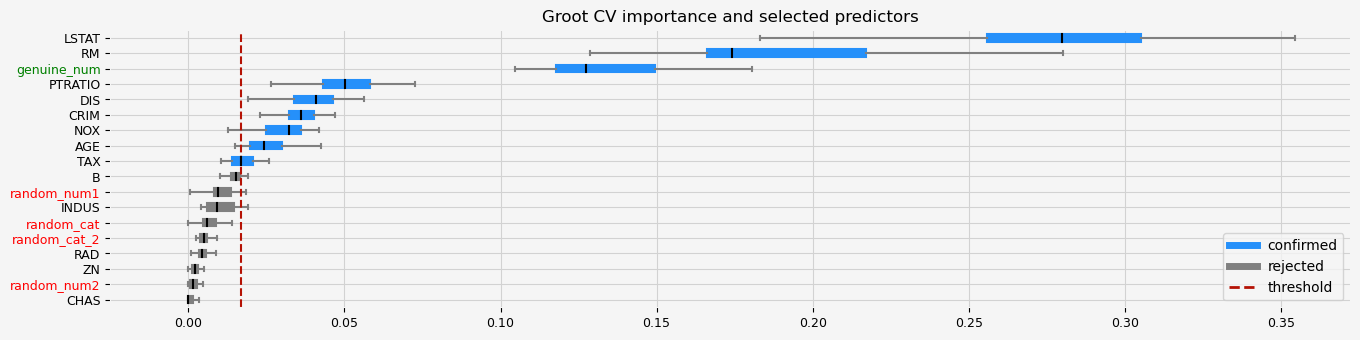

CPU times: total: 3min 55s
Wall time: 52.3 s


In [7]:
%%time
feat_selector = GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=5,
    n_iter=5,
    silent=True,
    fastshap=True,
    n_jobs=0,
    lgbm_params={"device": "gpu"},
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [8]:
%%time
feat_selector = GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=5,
    n_iter=5,
    silent=True,
    fastshap=True,
    n_jobs=0,
    lgbm_params={"device": "cuda"},
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

LightGBMError: CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1

## Leshy on GPU

In [9]:
model = LGBMRegressor(random_state=42, verbose=-1, device="gpu")

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
All relevant predictors selected in 00:00:02.63
The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']
The agnostic ranking: [1 7 3 8 1 1 1 1 4 2 1 1 1 2 7 3 5 1]
The naive ranking: ['RM', 'genuine_num', 'LSTAT', 'CRIM', 'NOX', 'DIS', 'AGE', 'PTRATIO', 'B', 'TAX', 'random_num1', 'INDUS', 'random_cat', 'RAD', 'random_cat_2', 'random_num2', 'ZN', 'CHAS']


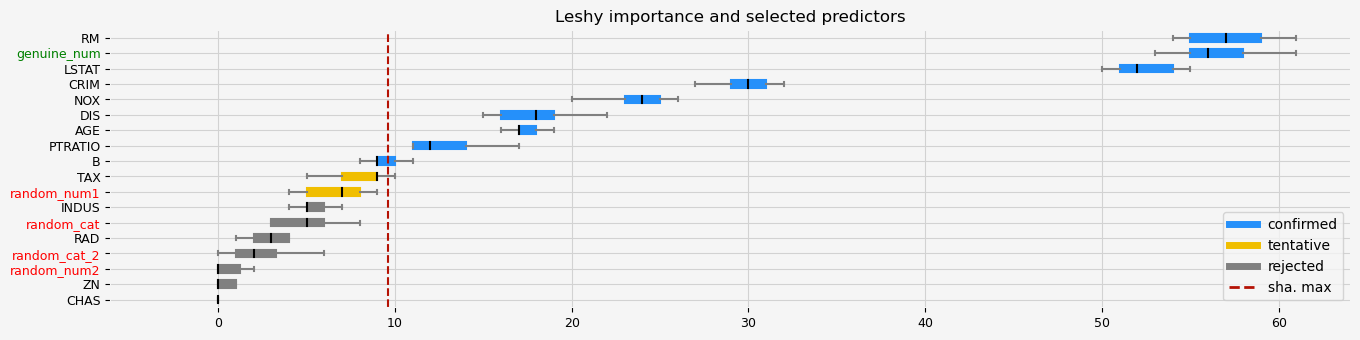

CPU times: total: 10.9 s
Wall time: 3.3 s


In [10]:
%%time
# Leshy
feat_selector = Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [11]:
model = LGBMRegressor(random_state=42, verbose=-1, device="cpu")

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
All relevant predictors selected in 00:00:00.44
The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']
The agnostic ranking: [1 7 3 8 1 1 1 1 4 2 1 1 1 2 7 3 5 1]
The naive ranking: ['RM', 'genuine_num', 'LSTAT', 'CRIM', 'NOX', 'DIS', 'AGE', 'PTRATIO', 'B', 'TAX', 'random_num1', 'INDUS', 'random_cat', 'RAD', 'random_cat_2', 'random_num2', 'ZN', 'CHAS']


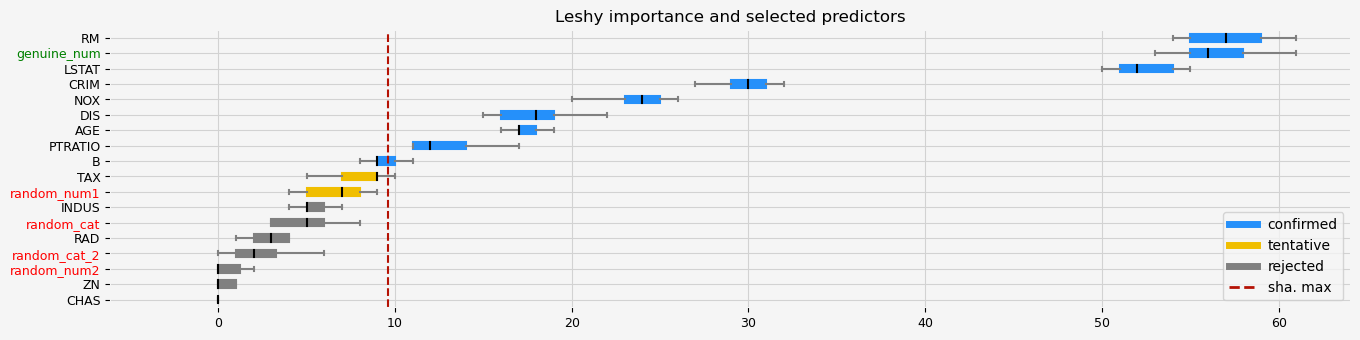

CPU times: total: 2.97 s
Wall time: 1.16 s


In [12]:
%%time
# Leshy
feat_selector = Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()